In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import glob
from sklearn import preprocessing
from pysptools import spectro as sp

In [27]:
class FolderAndFileProcessing:
    def ReadFilePaths(source, ext):
        return glob.glob(source + "/**/*." + ext, recursive = True)
    
    def ReadFile(file, rowToSkip, seperation):
        return pd.read_csv(file ,skiprows = rowToSkip, sep = seperation) 
    
    def GetValuesFromFile(file, rowToSkip, seperation, column):
        fileData = FolderAndFileProcessing.ReadFile(file , rowToSkip, seperation)
        return fileData[column]
    
    def WriteDictToExcel(targetPath, filename, dictionary):
        df = pd.DataFrame.from_dict(dictionary)
        os.makedirs(targetPath, exist_ok=True)
        df.to_excel(targetPath+filename)
        
class SpectraComparision:
    def MeanSquareRootComparision(fileList, spectraValue):
        mineralScore = {}
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            result = spectraValue - idealReflectance
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def MeanSquareRootComparisionNormalized(fileList, spectraValue):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            #print(idealReflectance, fileList[index])
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            result = normalized_spectraValue - normalized_idealReflectance
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def CrossCorrelation(fileList, spectraValue):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            result = np.corrcoef(normalized_spectraValue, normalized_idealReflectance)
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CrossCorrelationContinumRemoved(fileList, spectraValue):
        mineralScore = {}
        waveLength = list(range(350,2501))
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
            result = np.corrcoef(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CrossCorrelationContinumRemovedFaster(fileList, spectraValue, fileListContinumRemoval, waveLength):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.corrcoef(continumRemoved_spectraValue, continumRemoved_idealReflectance)
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore

### Variable Declarations

In [10]:
##txt file declarations
txtPath = "../data/enviData/cleanFolder/"
extensionTxt= 'txt'

###sed file declarations
sedPath = "../data/vulcano/"
extensionSed= 'sed'

### Populating paths

In [11]:
txt_files = FolderAndFileProcessing.ReadFilePaths(txtPath,extensionTxt)
sed_files = FolderAndFileProcessing.ReadFilePaths(sedPath,extensionSed)

In [12]:
for index in range(len(sed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.CrossCorrelationContinumRemoved(txt_files, testData)
    targetfilename = sed_files[index].replace('/data','/CrossCorrelationContinumRemovedScore').split('/')[-1].replace('.sed','.xlsx')
    list_string = sed_files[index].replace('/data','/CrossCorrelationContinumRemovedScore').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

TypeError: m > k must hold

### Faster Continum Removal

In [28]:
waveLength = list(range(350,2501))

In [18]:
fileListContinumRemoval = []
counter = 0
for index in range(len(txt_files)):
    idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
    normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
    continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
    fileListContinumRemoval.append(continumRemoved_idealReflectance)
    counter = counter + 1
    print('processed ' + str(counter))

processed 1
processed 2
processed 3
processed 4
processed 5
processed 6
processed 7
processed 8
processed 9
processed 10
processed 11
processed 12
processed 13
processed 14
processed 15
processed 16
processed 17
processed 18
processed 19
processed 20
processed 21
processed 22
processed 23
processed 24
processed 25
processed 26
processed 27
processed 28
processed 29
processed 30
processed 31
processed 32
processed 33
processed 34
processed 35
processed 36
processed 37
processed 38
processed 39
processed 40
processed 41
processed 42
processed 43
processed 44
processed 45
processed 46
processed 47
processed 48
processed 49
processed 50
processed 51
processed 52
processed 53
processed 54
processed 55
processed 56
processed 57
processed 58
processed 59
processed 60
processed 61
processed 62
processed 63
processed 64
processed 65
processed 66
processed 67
processed 68
processed 69
processed 70
processed 71
processed 72
processed 73
processed 74
processed 75
processed 76
processed 77
processe

processed 600
processed 601
processed 602
processed 603
processed 604
processed 605
processed 606
processed 607
processed 608
processed 609
processed 610
processed 611
processed 612
processed 613
processed 614
processed 615
processed 616
processed 617
processed 618
processed 619
processed 620
processed 621
processed 622
processed 623
processed 624
processed 625
processed 626
processed 627
processed 628
processed 629
processed 630
processed 631
processed 632
processed 633
processed 634
processed 635
processed 636
processed 637
processed 638
processed 639
processed 640
processed 641
processed 642
processed 643
processed 644
processed 645
processed 646
processed 647
processed 648
processed 649
processed 650
processed 651
processed 652
processed 653
processed 654
processed 655
processed 656
processed 657
processed 658
processed 659
processed 660
processed 661
processed 662
processed 663
processed 664
processed 665
processed 666
processed 667
processed 668
processed 669
processed 670
proces

In [29]:
for index in range(len(sed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.CrossCorrelationContinumRemovedFaster(txt_files, testData,fileListContinumRemoval, waveLength)
    targetfilename = sed_files[index].replace('/data','/CrossCorrelationContinumRemovedScore').split('/')[-1].replace('.sed','.xlsx')
    list_string = sed_files[index].replace('/data','/CrossCorrelationContinumRemovedScore').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

### Testing Data

In [30]:
###sed file declarations
testSedPath = "../testData/"
testSed_files = FolderAndFileProcessing.ReadFilePaths(testSedPath,extensionSed)

In [31]:
testSed_files

['../testData/ASTRO_00010_00001.sed',
 '../testData/ASTRO_00010_00002.sed',
 '../testData/ASTRO_00010_00003.sed',
 '../testData/ASTRO_00010_00006.sed',
 '../testData/ASTRO_00010_00004.sed',
 '../testData/ASTRO_00010_00005.sed']

In [7]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.CrossCorrelationContinumRemoved(txt_files, testData)
    targetfilename = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[-1].replace('.sed','.xlsx')
    list_string = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

In [32]:
testSed_files[0]

'../testData/ASTRO_00010_00001.sed'

In [33]:
tt = pd.read_csv(testSed_files[0] ,skiprows = 26, sep = '\t')

In [34]:
ww = tt['Reflect. [1.0]']

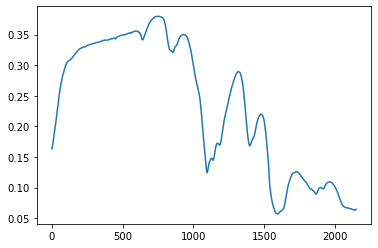

In [35]:
plt.plot(ww)

In [36]:
aa = sp.convex_hull_removal(ww,list(range(350,2501)))

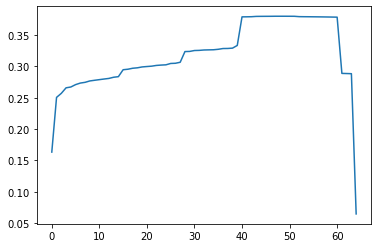

In [40]:
plt.plot(aa[2])

In [ ]:
num = list(range(350,2501))

In [ ]:
len(num)